In [360]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm

In [361]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.svm import SVC

# Анализ и подготовка датасета

In [362]:
df = pd.read_csv('/content/train_dataset_bank.csv', encoding="cp1251", sep=';')
df.head()

,id_contract,id_client,SIGN_DATE,IP_flag,TARGET,F1100,F1110,F1150,F1160,F1170,F1180,F1190,F1200,F1210,F1220,F1230,F1240,F1250,F1260,F1300,F1310,F1320,F1350,F1360,F1370,F1400,F1410,F1420,F1450,F1500,F1510,F1520,F1530,F1550,F1600,F1700,F2100,F2110,F2120,F2200,...,MANAGERCOUNTINREGION,MANAGERINNCOUNT,OKVED_CODE,PLAINTIFF_CASESNUMBER_YEAR,PLAINTIFF_SUM_YEAR,DEFENDANT_CASESNUMBER_YEAR,DEFENDANT_SUM_YEAR,THIRDOROTHERPERSON_YEAR,PLAINTIFF_CASESNUMBER_EVER,PLAINTIFF_SUM_EVER,DEFENDANT_CASESNUMBER_EVER,DEFENDANT_SUM_EVER,THIRDOROTHERPERSON_EVER,ADMITTEDNUMBER_233_YEAR,NOTADMITTEDNUMBER_233_YEAR,WINNERNUMBER_233_YEAR,SIGNEDNUMBER_233_YEAR,SUM_233_YEAR,ADMITTEDNUMBER_233_EVER,NOTADMITTEDNUMBER_233_EVER,WINNERNUMBER_233_EVER,SIGNEDNUMBER_233_EVER,SUM_233_EVER,ADMITTEDNUMBER_95_YEAR,NOTADMITTEDNUMBER_95_YEAR,WINNERNUMBER_95_YEAR,SIGNEDNUMBER_95_YEAR,SUM_95_YEAR,ADMITTEDNUMBER_95_EVER,NOTADMITTEDNUMBER_EVER,WINNERNUMBER_95_EVER,SIGNEDNUMBER_95_EVER,SUM_95_EVER,FLAG_DISQUALIFICATION,COUNT_CHANGE_YEAR,COUNT_CHANGE_EVER,BIRTHDATE,AGE,SEX_NAME,CITIZENSHIP_NAME
0,1,1847,01JAN2018:00:00:00,0,0,1.298961e+09,2154000.0,1.125573e+09,NaN,150010000.0,NaN,21224000.0,1.048287e+10,105901000.0,127510000.0,9.477348e+09,440671000.0,3.312980e+08,138000.0,1.960896e+09,1.000700e+07,-46634000.0,599497000.0,500000.0,1.028878e+09,340135000.0,NaN,340135000.0,NaN,9.480796e+09,2.499973e+09,6.907960e+09,NaN,NaN,1.178183e+10,1.178183e+10,2.370882e+09,5.294104e+10,5.057016e+10,631752000.0,...,0.0,0.0,35.14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,4650,01JAN2018:00:00:00,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,4770,01JAN2018:00:00:00,0,0,7.337400e+07,NaN,7.337400e+07,NaN,NaN,NaN,NaN,2.161000e+07,2378000.0,NaN,1.764200e+07,1000000.0,5.530000e+05,37000.0,9.073600e+07,1.000000e+05,NaN,6780000.0,NaN,8.385600e+07,NaN,NaN,NaN,NaN,4.248000e+06,NaN,4.171000e+06,77000.0,NaN,9.498400e+07,9.498400e+07,9.315000e+06,5.218400e+07,4.286900e+07,2569000.0,...,1.0,1.0,36.00.2,6.0,2762852.0,1.0,794.0,3.0,21.0,5408695.0,39.0,882647.0,4.0,1.0,0.0,1.0,1.0,1174998.0,2.0,0.0,2.0,2.0,2738217.0,38.0,0.0,38.0,39.0,4209963.0,169.0,0.0,169.0,168.0,18351739.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN
3,4,12237,01JAN2018:00:00:00,0,0,1.937488e+09,122828000.0,6.103280e+08,NaN,809426000.0,356828000.0,38078000.0,5.786965e+09,12001000.0,71000.0,1.232486e+09,78603000.0,4.459193e+09,4611000.0,2.685905e+09,1.516514e+09,NaN,NaN,65834000.0,1.103557e+09,627253000.0,NaN,689000.0,626564000.0,4.411295e+09,3.930000e+05,3.092581e+09,NaN,NaN,7.724453e+09,7.724453e+09,1.694054e+10,4.028466e+10,2.334412e+10,931118000.0,...,1.0,1.0,35.14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,9988,01JAN2018:00:00:00,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [363]:
len(df)

17891

In [364]:
# Проверили наличие дубликатов (полных дубликатов не обнаружено)

In [365]:
df.id_client.value_counts()

10092    293
5159     291
4613     278
5357     220
2483     182
        ... 
8170       1
6123       1
4088       1
2041       1
2049       1
Name: id_client, Length: 8922, dtype: int64

## Удаление колонок (1й этап)

Удалим некоторые для предсказания колонки:




> колонки с датами - для анализа табличных данных не нужны в прямом виде, можно поэкспериментировать с количеством дней между разными показателями (например, между DATEFIRSTREG и SIGN_DATE)



> id_contract - просто индекс




> id_client - категориальная колонка с очень большим количеством классов, не нужна для данного типа задачи







In [366]:
for col in df.columns:
    if 'DATE' in col:
        df[col] = pd.to_datetime(df[col].str.lower(), format='%d%b%Y:%H:%M:%S')

In [367]:
df['time_dif_1'] = (df.SIGN_DATE - df.DATEFIRSTREG).astype('timedelta64[D]') 
df['time_dif_2'] = (df.SIGN_DATE - df.TAXREG_REGDATE).astype('timedelta64[D]') 
df['time_dif_3'] = (df.SIGN_DATE - df.TAXREGPAY_REGDATE).astype('timedelta64[D]') 

In [368]:
df.drop(columns=['id_contract', 'id_client'], inplace=True)
df.drop(columns=['SIGN_DATE', 'DATEFIRSTREG', 'TAXREG_REGDATE', 'TAXREGPAY_REGDATE'], inplace=True)

Возможно, индекс клиента заменит собой колонки BIRTHDATE, AGE, SEX_NAME, CITIZENSHIP_NAME ДЛЯ текущего датасета (но не для новых данных, так как может быть новый клиент)

Удалим колонки с количеством пропусков > 70%

Все эти пропуски являются именно отсутствием данных (не можем принять Nan = 0, т.к. у категориальных признаков есть отдельный 0 и/или присутствует очень сильный дисбаланс в сторону Nan, а у числовых замена Nan на 0 выглядит неправильно, т.к. речь по большей части идёт о деньгах

In [369]:
empty_70_cols = []
for col in df.columns:
    if df[col].isna().sum() / len(df) >= 0.7:
        empty_70_cols.append(col)
        
df.drop(columns=empty_70_cols, inplace=True)
len(empty_70_cols)

56

In [370]:
# Неинформативные строки, пустые по сути, можно уалять
# (В итоговом варианте не удалил, заполнив пропуски.
# Это улучшило результат, но идейно так делать не стоит)

#null_60_index = df[df.isnull().sum(axis=1) > 60].index
# df_add = df.iloc[null_60_index]
#df.drop(index=null_60_index, inplace=True)

In [371]:
df.reset_index(drop=True, inplace=True)

In [372]:
df.head()

,IP_flag,TARGET,F1100,F1150,F1200,F1210,F1230,F1250,F1300,F1310,F1370,F1500,F1520,F1600,F1700,F2100,F2110,F2120,F2200,F2300,F2340,F2350,F2400,F2410,F1150_LAG1,F1230_LAG1,F1520_LAG1,F2110_LAG1,F2120_LAG1,F2200_LAG1,F2300_LAG1,F2400_LAG1,EGRPOINCLUDED,OKFS_GROUP,OKOPF_GROUP,OKOGU_GROUP,OKATO_REGIONCODE,OKATO_FED,OKTMO_CODE,OKTMO_FED,WORKERSRANGE,COUNTCOOWNERFCSM,COUNTCOOWNERROSSTAT,COUNTCOOWNEREGRUL,COUNTBRANCH,COUNTBRANCHROSSTAT,COUNTBRANCHEGRUL,TELEPHONECOUNT,MANAGERCOUNTINCOUNTRY,MANAGERCOUNTINREGION,MANAGERINNCOUNT,OKVED_CODE,ADMITTEDNUMBER_95_YEAR,NOTADMITTEDNUMBER_95_YEAR,WINNERNUMBER_95_YEAR,SIGNEDNUMBER_95_YEAR,SUM_95_YEAR,ADMITTEDNUMBER_95_EVER,NOTADMITTEDNUMBER_EVER,WINNERNUMBER_95_EVER,SIGNEDNUMBER_95_EVER,SUM_95_EVER,time_dif_1,time_dif_2,time_dif_3
0,0,0,1.298961e+09,1.125573e+09,1.048287e+10,105901000.0,9.477348e+09,3.312980e+08,1.960896e+09,1.000700e+07,1.028878e+09,9.480796e+09,6.907960e+09,1.178183e+10,1.178183e+10,2.370882e+09,5.294104e+10,5.057016e+10,631752000.0,8.834700e+07,1.122418e+09,1.479338e+09,3.908700e+07,-19204000.0,1.031700e+09,9.179060e+09,7.426504e+09,4.955724e+10,4.648680e+10,5.565080e+08,2.401140e+08,7.625800e+07,1.0,Частная собственность,Коммерческая корпоративная организация,Группировки хозяйствующих субъектов и обществе...,3.0,40.0,3.701000e+09,40.0,1001 .. 5000,5.0,1.0,0.0,8.0,7.0,7.0,3.0,0.0,0.0,0.0,35.14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8910.0,4202.0,21185.0
1,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,0,7.337400e+07,7.337400e+07,2.161000e+07,2378000.0,1.764200e+07,5.530000e+05,9.073600e+07,1.000000e+05,8.385600e+07,4.248000e+06,4.171000e+06,9.498400e+07,9.498400e+07,9.315000e+06,5.218400e+07,4.286900e+07,2569000.0,1.190000e+06,6.500000e+04,1.494000e+06,6.550000e+05,NaN,7.067400e+07,1.825700e+07,3.764000e+06,5.134000e+07,4.299900e+07,3.249000e+06,1.265000e+06,6.800000e+05,1.0,Государственная собственность,Коммерческая унитарная организация,Группировки хозяйствующих субъектов и обществе...,33.0,33.0,3.371000e+10,33.0,51 .. 100,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,36.00.2,38.0,0.0,38.0,39.0,4209963.0,169.0,0.0,169.0,168.0,18351739.0,9463.0,5603.0,21185.0
3,0,0,1.937488e+09,6.103280e+08,5.786965e+09,12001000.0,1.232486e+09,4.459193e+09,2.685905e+09,1.516514e+09,1.103557e+09,4.411295e+09,3.092581e+09,7.724453e+09,7.724453e+09,1.694054e+10,4.028466e+10,2.334412e+10,931118000.0,1.489204e+09,1.283591e+09,1.335281e+09,1.102019e+09,256172000.0,5.929800e+08,1.398821e+09,3.987467e+09,3.873078e+10,2.170760e+10,1.032720e+09,1.525138e+09,1.201213e+09,1.0,Частная собственность,Коммерческая корпоративная организация,Группировки хозяйствующих субъектов и обществе...,71.0,34.0,7.187600e+10,34.0,501 .. 1000,1.0,1.0,1.0,0.0,0.0,2.0,8.0,1.0,1.0,1.0,35.14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4567.0,4567.0,21185.0
4,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Заполнение пропусков

In [373]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17891 entries, 0 to 17890
Data columns (total 65 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   IP_flag                    17891 non-null  int64  
 1   TARGET                     17891 non-null  int64  
 2   F1100                      6936 non-null   float64
 3   F1150                      6341 non-null   float64
 4   F1200                      11850 non-null  float64
 5   F1210                      9735 non-null   float64
 6   F1230                      11484 non-null  float64
 7   F1250                      11610 non-null  float64
 8   F1300                      11850 non-null  float64
 9   F1310                      7704 non-null   float64
 10  F1370                      7495 non-null   float64
 11  F1500                      11614 non-null  float64
 12  F1520                      11478 non-null  float64
 13  F1600                      11870 non-null  flo

In [374]:
F_cols = list(filter(lambda x: x.startswith('F'), df.columns))
len(F_cols)

30

In [375]:
# Заменим Null в числовых фичах, группируя по некоторым категориальным признакам, в которых мало пропусков

help_cols = ['OKFS_GROUP', 'OKOPF_GROUP', 'OKOGU_GROUP', 'WORKERSRANGE']

for col in F_cols:
    for  key, value in df[[*help_cols, col]].groupby(help_cols).indices.items():
        df[col].loc[value] = df[col].loc[value].fillna(df[col].loc[value].median())

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


## Проверка признаков на зависимость и удаление колонок (2й этап)

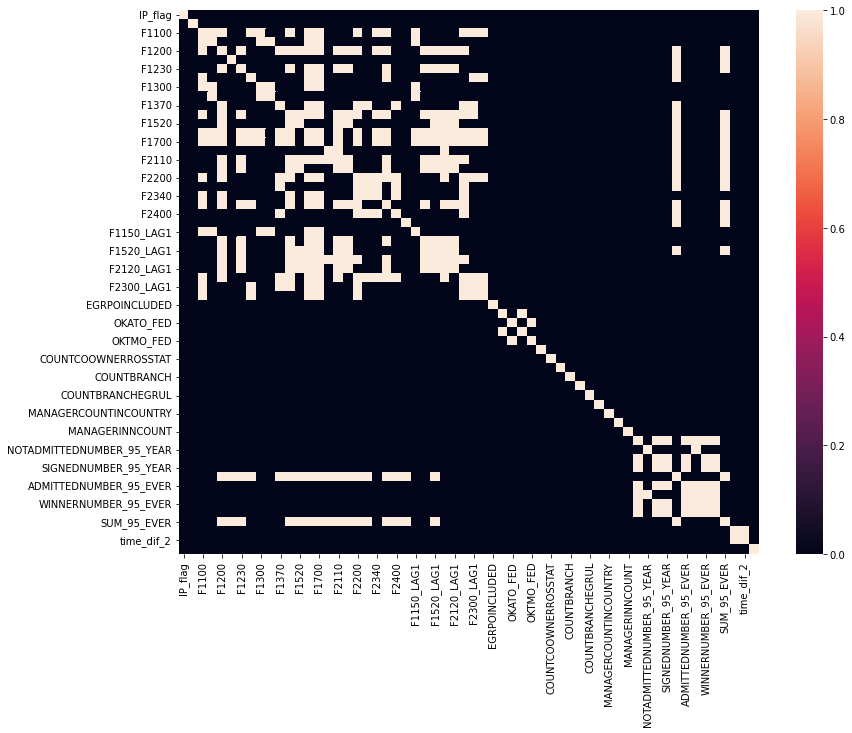

In [376]:
plt.figure(figsize=(13, 10))
sns.heatmap(df.corr()>0.7)

Устраим мультиколлинеарность

In [377]:
milti_cols = df.corr()[(df.corr() > 0.7).sum() > 5].index
df.drop(columns=milti_cols, inplace=True)

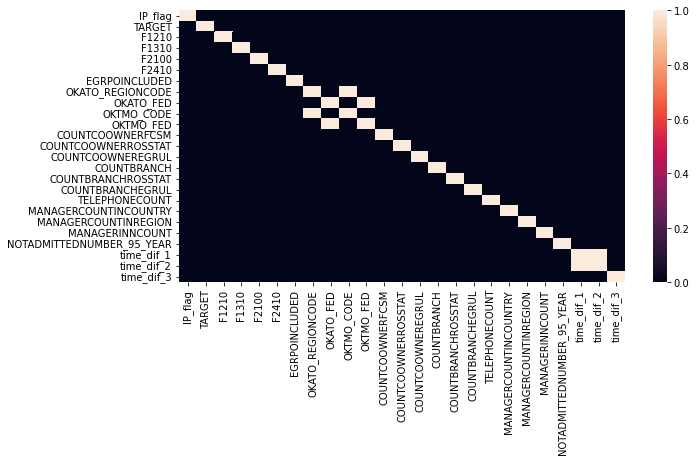

In [378]:
plt.figure(figsize=(10, 5))
sns.heatmap(df.corr()>0.7)

In [379]:
df.drop(columns=['OKTMO_FED', 'OKTMO_CODE', 'time_dif_2'], inplace=True)

In [380]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17891 entries, 0 to 17890
Data columns (total 27 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   IP_flag                    17891 non-null  int64  
 1   TARGET                     17891 non-null  int64  
 2   F1210                      17527 non-null  float64
 3   F1310                      17506 non-null  float64
 4   F2100                      17524 non-null  float64
 5   F2410                      17489 non-null  float64
 6   EGRPOINCLUDED              14391 non-null  float64
 7   OKFS_GROUP                 14391 non-null  object 
 8   OKOPF_GROUP                14391 non-null  object 
 9   OKOGU_GROUP                14388 non-null  object 
 10  OKATO_REGIONCODE           16559 non-null  float64
 11  OKATO_FED                  16555 non-null  float64
 12  WORKERSRANGE               13911 non-null  object 
 13  COUNTCOOWNERFCSM           14295 non-null  flo

Оставшиеся пропуски можно заполнить на общих основаниях

In [381]:
df.fillna(df.median(), inplace=True)

# Построение модели

In [382]:
num_cols = df.select_dtypes([int, float]).drop(columns='TARGET').columns
str_cols = df.select_dtypes(object).columns

In [383]:
def simple_pred(clf, data=df[num_cols], target=df.TARGET):
    clf.fit(data, target)
    preds = clf.predict(data)    
    print(classification_report(preds, target))

## Работа с числовыми признаками

### LogisticRegression BASELINE на числовых признаках

Построим BASELINE на int и float признаках

In [384]:
clf = LogisticRegressionCV(penalty='l2', cv=5, scoring='f1')

In [385]:
simple_pred(clf)

              precision    recall  f1-score   support

           0       0.95      0.58      0.72     17050
           1       0.04      0.36      0.07       841

    accuracy                           0.57     17891
   macro avg       0.49      0.47      0.40     17891
weighted avg       0.91      0.57      0.69     17891



In [386]:
# По сути модель выдает постоянный 0. Её точность близка к точности случайного классификатора

### KNearestNeighbors

In [387]:
clf = KNeighborsClassifier(weights='distance')

In [388]:
simple_pred(clf)

              precision    recall  f1-score   support

           0       1.00      0.99      0.99     10626
           1       0.98      1.00      0.99      7265

    accuracy                           0.99     17891
   macro avg       0.99      0.99      0.99     17891
weighted avg       0.99      0.99      0.99     17891



Видим, что метод ближайших соседей хорошо адаптируется под выборку, провалидируем модель (так как алгоритм переобучился, а нам нужна правильная оценка его качества) и посмотрим на результат

In [389]:
print(cross_val_score(clf, df[num_cols], df.TARGET, cv=5, scoring='f1_macro').mean())

0.7679175517650989


Получили неплохие результаты

Постараемся улучшить результат, подобрав гиперпараметры

In [390]:
f1_macro_list = []
for n in tqdm(range(2, 50)):
    clf = KNeighborsClassifier(n_neighbors=n, weights='distance')
    f1_macro_list.append(cross_val_score(clf, df[num_cols], df.TARGET, cv=5, scoring='f1_macro').mean())

100%|██████████| 48/48 [04:12<00:00,  5.26s/it]


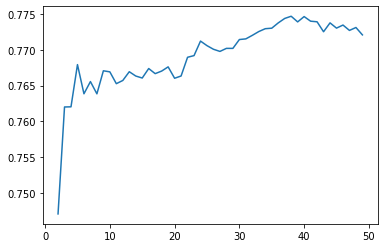

In [391]:
plt.plot(np.arange(2, 50), f1_macro_list)
plt.show()

In [392]:
best_n = 2 + np.array(f1_macro_list).argmax() # – Лучший показатель по количеству

In [393]:
best_n

38

In [394]:
max(f1_macro_list) # – Лучшее качество

0.7746752072109655

In [395]:
clf = KNeighborsClassifier(weights='distance', n_neighbors=best_n)
print(cross_val_score(clf, df[num_cols], df.TARGET, cv=5, scoring='f1_macro').mean())

0.7746752072109655


### RandomForest


In [396]:
clf = RandomForestClassifier(100)

In [397]:
print(cross_val_score(clf, df[num_cols], df.TARGET, cv=5, scoring='f1_macro').mean())

0.7446682643439654


Качество примерно такое же

# Добавим категориальные фичи

### Сначала заполним в них пропуски

In [398]:
df[str_cols] = df[str_cols].fillna(df[str_cols].mode().iloc[0])

In [399]:
df[str_cols].head()

,OKFS_GROUP,OKOPF_GROUP,OKOGU_GROUP,WORKERSRANGE,OKVED_CODE
0,Частная собственность,Коммерческая корпоративная организация,Группировки хозяйствующих субъектов и обществе...,1001 .. 5000,35.14
1,Частная собственность,Коммерческая корпоративная организация,Группировки хозяйствующих субъектов и обществе...,0 .. 5,46.46
2,Государственная собственность,Коммерческая унитарная организация,Группировки хозяйствующих субъектов и обществе...,51 .. 100,36.00.2
3,Частная собственность,Коммерческая корпоративная организация,Группировки хозяйствующих субъектов и обществе...,501 .. 1000,35.14
4,Частная собственность,Коммерческая корпоративная организация,Группировки хозяйствующих субъектов и обществе...,0 .. 5,46.46


## Кодирование

WORKERSRANGE сделаем labeling вручную, т.к. это ранговоая переменная

In [400]:
df.WORKERSRANGE.value_counts()

0 .. 5          10163
16 .. 50         2181
6 .. 10          1668
51 .. 100         791
11 .. 15          656
1001 .. 5000      592
501 .. 1000       557
251 .. 500        508
101 .. 150        258
151 .. 200        186
201 .. 250        166
5000 и более      165
Name: WORKERSRANGE, dtype: int64

In [401]:
df.WORKERSRANGE = df.WORKERSRANGE.str.split(' ', expand=True, n=1)[0]

У колонки OKVED_CODE слишком много классов и сильный дисбаланс.

Сожмём редкие категории и попытаемся выстроить баланс

In [402]:
df.OKVED_CODE.value_counts()

46.46      2924
41.20       664
46.46.1     539
46.31       422
46.69.8     414
           ... 
15.20         1
32.12.5       1
58.29         1
52.10.9       1
25.21.2       1
Name: OKVED_CODE, Length: 773, dtype: int64

In [403]:
rare_index_50 = df.OKVED_CODE.value_counts()[df.OKVED_CODE.value_counts()<50].index
df.OKVED_CODE[df.OKVED_CODE.isin(rare_index_50)] = 'special_50'

rare_index_100 = df.OKVED_CODE.value_counts()[df.OKVED_CODE.value_counts()<100].index
df.OKVED_CODE[df.OKVED_CODE.isin(rare_index_100)] = 'special_100'

rare_index_200 = df.OKVED_CODE.value_counts()[df.OKVED_CODE.value_counts()<200].index
df.OKVED_CODE[df.OKVED_CODE.isin(rare_index_200)] = 'special_200'

rare_index_1000 = df.OKVED_CODE.value_counts()[df.OKVED_CODE.value_counts()<1000].index
df.OKVED_CODE[df.OKVED_CODE.isin(rare_index_1000)] = 'special_1000'

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is tr

In [404]:
df.OKVED_CODE.value_counts()

special_50      5071
special_1000    4588
46.46           2924
special_200     2846
special_100     2462
Name: OKVED_CODE, dtype: int64

Готово, перейдём к ohe

In [405]:
enc = OneHotEncoder(handle_unknown='ignore')

In [406]:
enc.fit(df[['OKFS_GROUP', 'OKOPF_GROUP', 'OKOGU_GROUP', 'OKVED_CODE']])

OneHotEncoder(handle_unknown='ignore')

In [407]:
enc.categories_

[array(['Государственная собственность', 'Иностранная собственность',
        'Смешенная российская собственность',
        'Совместная российская и иностранная собственность',
        'Частная собственность'], dtype=object),
 array(['Без прав юридического лица',
        'Коммерческая корпоративная организация',
        'Коммерческая унитарная организация',
        'Некоммерческая корпоративная организация',
        'Некоммерческая унитарная организация'], dtype=object),
 array(['Государственная власть в РФ',
        'Государственная власть в субъектах РФ',
        'Группировки хозяйствующих субъектов и общественных объединений',
        'Местное самоуправление в РФ'], dtype=object),
 array(['46.46', 'special_100', 'special_1000', 'special_200',
        'special_50'], dtype=object)]

In [408]:
data_ohe = enc.transform(df[['OKFS_GROUP', 'OKOPF_GROUP', 'OKOGU_GROUP', 'OKVED_CODE']]).toarray()

In [409]:
ohe_names = enc.get_feature_names_out(['OKFS_GROUP', 'OKOPF_GROUP', 'OKOGU_GROUP', 'OKVED_CODE'])


In [410]:
df = df.join(pd.DataFrame(data=data_ohe, columns=ohe_names))

In [411]:
ohe_names

array(['OKFS_GROUP_Государственная собственность',
       'OKFS_GROUP_Иностранная собственность',
       'OKFS_GROUP_Смешенная российская собственность',
       'OKFS_GROUP_Совместная российская и иностранная собственность',
       'OKFS_GROUP_Частная собственность',
       'OKOPF_GROUP_Без прав юридического лица',
       'OKOPF_GROUP_Коммерческая корпоративная организация',
       'OKOPF_GROUP_Коммерческая унитарная организация',
       'OKOPF_GROUP_Некоммерческая корпоративная организация',
       'OKOPF_GROUP_Некоммерческая унитарная организация',
       'OKOGU_GROUP_Государственная власть в РФ',
       'OKOGU_GROUP_Государственная власть в субъектах РФ',
       'OKOGU_GROUP_Группировки хозяйствующих субъектов и общественных объединений',
       'OKOGU_GROUP_Местное самоуправление в РФ', 'OKVED_CODE_46.46',
       'OKVED_CODE_special_100', 'OKVED_CODE_special_1000',
       'OKVED_CODE_special_200', 'OKVED_CODE_special_50'], dtype=object)

# Продолжаем тестирование моделей

In [412]:
X = df[num_cols].join(df[ohe_names])

In [413]:
clf = KNeighborsClassifier(weights='distance', n_neighbors=best_n)
print('KNeighborsClassifier:', end=' ')
print(cross_val_score(clf, X, df.TARGET, cv=5, scoring='f1_macro').mean())

clf = RandomForestClassifier(100)
print('RandomForestClassifier:', end=' ')
print(cross_val_score(clf, X, df.TARGET, cv=5, scoring='f1_macro').mean())

KNeighborsClassifier: 0.7746752072109655
RandomForestClassifier: 0.7692246715963229


Немного улучшили качество, причем для обеих моделей

Вспомним про нормализацию, посмотрим, улучшится ли качество

## Нормализация

In [414]:
scaler = StandardScaler()
scaler.fit(X)

StandardScaler()

In [415]:
X_scaled = scaler.transform(X)

clf = KNeighborsClassifier(weights='distance', n_neighbors=best_n)
print('KNeighborsClassifier:', end=' ')
print(cross_val_score(clf, X_scaled, df.TARGET, cv=5, scoring='f1_macro').mean())

clf = RandomForestClassifier(200)
print('RandomForestClassifier:', end=' ')
print(cross_val_score(clf, X_scaled, df.TARGET, cv=5, scoring='f1_macro').mean())



KNeighborsClassifier: 0.8117517068444057
RandomForestClassifier: 0.772371423605253


Результаты соседей улучшились сильнее, как и ожидалось

### SVM

In [416]:
for kernel in ['linear', 'rbf', 'sigmoid']:
    clf = SVC(kernel=kernel, gamma='auto')
    print(kernel, end=': -> ')
    print(cross_val_score(clf, X_scaled, df.TARGET, cv=5, scoring='f1_macro').mean())

linear: -> 0.7180378825898482
rbf: -> 0.7467102379455846
sigmoid: -> 0.6219301589000209


## Ансамбли

### Bagging

In [417]:
clf = BaggingClassifier(KNeighborsClassifier(weights='distance', n_neighbors=best_n),
                        n_estimators=10,
                        random_state=42)
print('KNeighborsClassifier:', end=' ')
print(cross_val_score(clf, X_scaled, df.TARGET, cv=5, scoring='f1_macro').mean())

clf = BaggingClassifier(RandomForestClassifier(200),
                        n_estimators=10,
                        random_state=42)
print('RandomForestClassifier:', end=' ')
print(cross_val_score(clf, X_scaled, df.TARGET, cv=5, scoring='f1_macro').mean())

KNeighborsClassifier: 0.8109024118061761
RandomForestClassifier: 0.7699255355258615


Результат не изменился

### GradientBoostingClassifier

In [418]:
clf = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,
                                 random_state=0)
print('GradientBoostingClassifier:', end=' ')
print(cross_val_score(clf, X_scaled, df.TARGET, cv=5, scoring='f1_macro').mean())


GradientBoostingClassifier: 0.5999707054251925


### VotingClassifier

In [419]:
clf1 = KNeighborsClassifier(weights='distance', n_neighbors=best_n)
clf2 = BaggingClassifier(RandomForestClassifier(200), n_estimators=10, random_state=42)
clf3 = SVC(gamma='auto', kernel='rbf')

eclf = VotingClassifier(
     estimators=[('knn', clf1), ('rf', clf2), ('svc', clf3)],
     voting='hard')

In [420]:
print('VotingClassifier:', end=' ')
print(cross_val_score(eclf, X_scaled, df.TARGET, cv=5, scoring='f1_macro').mean())


VotingClassifier: 0.8083215165002995


## ИТОГО

f1 = 0.8117517068444057

(38 ближайших соседей)
